This Jupyter file serves to test different visualizations without having to run the entire code over again

In [37]:
#-------------------------#
# Variable Initialization #
#-------------------------#

import numpy as np
from matplotlib import pyplot as plt

#variable setup
T_air = 20 + 273.15 #kelvin
L_1 = 1.20 #meters, core length
L_2 = 0.25 #meters, handle length
r_core = 0.02 #meters, radius of core (and handle)
k_core = 0.35 #W/mK
k_handle = 0.05 #W/mK
R_tc = 10e-5 #m^2K/W, thermal resistance of handle-core boundary
R_tc_luke = 10e-20 #m^2K/W, thermal resistance of luke-handle boundary
T_luke = 37.1 + 273.15 #kelvin, temperature of Luke's hand
qdot_r0 = 10**6
h = 50 #W/m^2k
pi = np.pi
alpha = 1


In [38]:
#----------------#
# Node Variables #
#----------------#

n = 40  #number of nodes in the radial direction 
m = 200 #number of nodes in the axial direction in the core
M = 80  #number of nodes in the axial direction in the handle

tolerance = 0.01 #desired final tempreature variation between iterations

In [39]:
#-------------------------#
# Variables and Functions #
#-------------------------#

nInd = n - 1 #for the purpose of indexing 
mInd = m - 1 #for the purpose of indexing 
MInd = M - 1 #for the purpose of indexing 

dr = r_core/(n-1)
dx_c = L_1/(m-1)
dx_h = L_2/(M-1)

T_core = np.zeros((n,m))
T_core_last = np.zeros((n,m))
t_core_updated = np.zeros((n,m))
T_handle = np.zeros((n,M))
T_handle_last = np.zeros((n,M))
t_handle_updated = np.zeros((n,M))

deltaTcore = 1 #maximum variation between iterations

def r(i): #radius at node i
    return (r_core/(nInd))*i

def qgen(r1,r2,dx): #calcluate the heat generated in a cylindrical volume
    return qdot_r0*pi*(dx)*((r2**2-r1**2) + ((1/(2*r_core**2))*(r1**4-r2**4)))

def aAnn(r1,r2): #calculate the area of an annulus
    return pi*(r2**2 - r1**2)

def aCyl(r,h):
    return 2*pi*r*h

In [40]:
#------------#
# Iterations #
#------------#

iterationCounter = 0
while deltaTcore > tolerance:
    #center edge nodes "corners"
    T_core[0,mInd] = (T_core_last[0,mInd-1]*(k_core*pi*(dr/2)**2/(dx_c/2)) + 
                      T_core_last[1,mInd]*(2*pi*k_core*dx_c/2) + 
                      qgen(0,dr/2,dx_c/2) + T_air*h*pi*(dr/2)**2*(dx_c/2)) / ((pi*(dr/2)**2*((2*k_core/2) + h)) + (2*pi*k_core*(dx_c/2)))
    T_core[0,0] = (T_core_last[0,1]*(k_core*aAnn(0,dr/2)/(dx_c/2)) + 
                   T_core_last[1,0]*(k_core*aCyl(dr/2,dx_c)/(dr/2)) + 
                   T_handle_last[0,0]*(aAnn(0,dr/2)/(R_tc)) + 
                   qgen(0,dr/2,dx_c/2)) / ((k_core*aAnn(0,dr/2)/(dx_c/2)) + (k_core*aCyl(dr/2,dx_c)/(dr/2)) + (aAnn(0,dr/2)/(R_tc)))
    
    #outer edge nodes "corners"
    T_core[nInd,mInd] = (T_core_last[nInd-1,mInd]*(k_core*aCyl((r_core - dr/2),dx_c/2)/(dr/2)) + 
                         T_core_last[nInd,mInd-1]*(k_core*aAnn((r_core - (dr/2)),r_core)/(dx_c/2)) + 
                         T_air*(h*(aCyl(r_core,(dx_c/2)) + aAnn(r_core,(r_core - (dr/2))))) + 
                         qgen((r_core - dr/2),r_core,dx_c/2)) / ((k_core*aCyl((r_core - dr/2),dx_c/2)/(dr/2)) + (k_core*aAnn((r_core - (dr/2)),r_core)/(dx_c/2)) + (h*(aCyl(r_core,(dx_c/2)) + aAnn(r_core,(r_core - (dr/2))))))
    T_core[nInd,0] = (T_core_last[nInd-1,0]*(k_core*aCyl(r_core - (dr/2),dx_c/2)/(dr/2)) +
                      T_core_last[nInd,1]*(k_core*aAnn(r_core-(dr/2),r_core)/(dx_c/2)) +
                      T_handle_last[nInd,0]*(aAnn(r_core-(dr/2),r_core)/R_tc) + 
                      T_air*(h*aCyl(r_core,dx_c/2)) + 
                      qgen(r_core - (dr/2),r_core,(dx_c/2))) / ((k_core*aCyl(r_core - (dr/2),dx_c/2)/(dr/2)) + (k_core*aAnn(r_core-(dr/2),r_core)/(dx_c/2)) + (h*aCyl(r_core,dx_c/2)) + (aAnn(r_core-(dr/2),r_core)/R_tc))
    
    #core center nodes ("side")
    j = 1
    while j < mInd:
        T_core[0,j] = (T_core_last[1,j]*k_core*aCyl(dr/2,dx_c)/(dr/2) +
                       T_core_last[0,j-1]*k_core*aAnn(0,dr/2)/dx_c + 
                       T_core_last[0,j+1]*k_core*aAnn(0,dr/2)/dx_c + 
                       qgen(0,dr/2,dx_c)) / (k_core*aCyl(dr/2,dx_c)/(dr/2) + 2*k_core*aAnn(0,dr/2)/dx_c)
        j += 1

    #center of core handle contact nodes ("side")
    i = 1
    while i < nInd:
        T_core[i,0] = (T_core_last[i-1,0]*(k_core*aCyl(r(i) - (dr/2),dx_c/2)/dr) + 
                       T_core_last[i+1,0]*(k_core*aCyl(r(i) + (dr/2),dx_c/2)/dr) +
                       T_core_last[i,1]*(k_core*aAnn(r(i) - (dr/2),r(i) + (dr/2))/(dx_c/2)) + 
                       T_handle_last[i,0]*(aAnn(r(i) - (dr/2),r(i) + (dr/2))/R_tc) + 
                       qgen(r(i) - (dr/2),r(i) + (dr/2),dx_c/2)) / ((k_core*aCyl(r(i) - (dr/2),dx_c/2)/dr) + (k_core*aCyl(r(i) + (dr/2),dx_c/2)/dr) + (k_core*aAnn(r(i) - (dr/2),r(i) + (dr/2))/(dx_c/2)) + (aAnn(r(i) - (dr/2),r(i) + (dr/2))/R_tc))
        i += 1

    #edge of core nodes ("side")
    j = 1
    while j < mInd:
        T_core[nInd,j] = (T_core_last[nInd,j-1]*(k_core*aAnn(r(nInd) - (dr/2),r(nInd))/dx_c) + 
                          T_core_last[nInd,j+1]*(k_core*aAnn(r(nInd) - (dr/2),r(nInd))/dx_c) + 
                          T_core_last[nInd-1,j]*(k_core*aCyl(r(nInd) - (dr/2),dx_c)/(dr/2)) + 
                          T_air*(h*aCyl(r(nInd),dx_c)) +
                          qgen(r(nInd) - (dr/2),r(nInd),dx_c)) / ((k_core*aAnn(r(nInd) - (dr/2),r(nInd))/dx_c) + (k_core*aAnn(r(nInd) - (dr/2),r(nInd))/dx_c) + (k_core*aCyl(r(nInd) - (dr/2),dx_c)/(dr/2)) + (h*aCyl(r(nInd),dx_c)))
        j += 1

    #core tip nodes ("side")
    i = 1
    while i < nInd:
        T_core[i,mInd] = (T_core_last[i,mInd-1]*(k_core*aAnn(r(i) - (dr/2),r(i) + (dr/2))/(dx_c/2)) +
                          T_core_last[i-1,mInd]*(k_core*aCyl(r(i) - (dr/2),dx_c/2)/dr) + 
                          T_core_last[i+1,mInd]*(k_core*aCyl(r(i) + (dr/2),dx_c/2)/dr) + 
                          T_air*(h*aAnn(r(i) - (dr/2),r(i) + (dr/2))) + 
                          qgen(r(i) - (dr/2),r(i) + (dr/2),dx_c/2)) / ((k_core*aAnn(r(i) - (dr/2),r(i) + (dr/2))/(dx_c/2)) + (k_core*aCyl(r(i) - (dr/2),dx_c/2)/dr) + (k_core*aCyl(r(i) + (dr/2),dx_c/2)/dr) + (h*aAnn(r(i) - (dr/2),r(i) + (dr/2))))
        i += 1

    #interior nodes
    i = 1
    while i < nInd:
        j = 1
        while j < mInd:
            T_core[i,j] = (T_core_last[i-1,j]*(k_core*aCyl(r(i) - (dr/2),dx_c)/dr) + 
                           T_core_last[i+1,j]*(k_core*aCyl(r(i) + (dr/2),dx_c)/dr) + 
                           T_core_last[i,j-1]*(k_core*aAnn(r(i) - (dr/2),r(i) + (dr/2))/dx_c) + 
                           T_core_last[i,j+1]*(k_core*aAnn(r(i) - (dr/2),r(i) + (dr/2))/dx_c) + 
                           qgen(r(i) - (dr/2),r(i) + (dr/2),dx_c)) / ((k_core*aCyl(r(i) - (dr/2),dx_c)/dr) + (k_core*aCyl(r(i) + (dr/2),dx_c)/dr) + 2*(k_core*aAnn(r(i) - (dr/2),r(i) + (dr/2))/dx_c))
            j += 1
        i += 1

    #the below is bugged somehow NOT ANYMORE HEHEHE
    #repeat for the handle, but with these changes:
    # - instead of convection there is contact resistance between the handle and luke's skin
    # - use handle instead of core
    # - use MInd instead of mInd
    # - use dx_h instead of dx_c
    # - no qgen
    # - there is certainly a better way to do this with a function which i may implement

    #center edge nodes "corners"

    T_handle[0,MInd] = (T_handle_last[0,MInd-1]*(k_handle*aAnn(0,dr/2)/(dx_h/2)) + 
                        T_handle_last[1,MInd]*(k_handle*aCyl(dr/2,dx_h/2)/(dr/2)) + 
                        T_luke*(aAnn(0,dr/2)/R_tc_luke)) / ((k_handle*aAnn(0,dr/2)/(dx_h/2)) + (k_handle*aCyl(dr/2,dx_h/2)/(dr/2)) + (aAnn(0,dr/2)/R_tc_luke))

    T_handle[0,0] = (T_handle_last[0,1]*(k_handle*aAnn(0,dr/2)/(dx_h/2)) +
                     T_handle_last[1,0]*(k_handle*aCyl(dr/2,dx_h/2)/(dr/2)) + 
                     T_core_last[0,0]*(aAnn(0,dr/2)/R_tc)) / ((k_handle*aAnn(0,dr/2)/(dx_h/2)) + (k_handle*aCyl(dr/2,dx_h/2)/(dr/2)) + (aAnn(0,dr/2)/R_tc))

    #outer edge nodes "coner"
    T_handle[nInd,MInd] = (T_handle_last[nInd-1,MInd]*(k_handle*aCyl(r_core - dr/2,dx_h/2)/(dr/2)) + 
                           T_handle_last[nInd,MInd-1]*(k_handle*aAnn(r_core - dr/2,r_core)/(dx_h/2)) + 
                           T_luke*((aCyl(r_core,dx_h/2) + aAnn(r_core + dr/2,r_core))/(R_tc_luke))) / ((k_handle*aCyl(r_core - dr/2,dx_h/2)/(dr/2)) + (k_handle*aAnn(r_core - dr/2,r_core)/(dx_h/2)) + ((aCyl(r_core,dx_h/2) + aAnn(r_core + dr/2,r_core))/(R_tc_luke)))
    
    T_handle[nInd,0] = (T_handle_last[nInd-1,0]*(k_handle*aCyl(r_core - dr/2,dx_h/2)/(dr/2)) + 
                        T_handle_last[nInd,1]*(k_handle*aAnn(r_core - dr/2,r_core)/(dx_h/2)) + 
                        T_luke*(aCyl(r_core,dx_h/2)/R_tc_luke) + 
                        T_core_last[nInd,0]*(aAnn(r_core - dr/2,r_core)/R_tc)) / ((k_handle*aCyl(r_core - dr/2,dx_h/2)/(dr/2)) + (k_handle*aAnn(r_core - dr/2,r_core)/(dx_h/2)) + (aCyl(r_core,dx_h/2)/R_tc_luke) + (aAnn(r_core - dr/2,r_core)/R_tc))
    
    #handle center nodes "side"
    j = 1
    while j < MInd:
        T_handle[0,j] = (T_handle_last[1,j]*(k_handle*aCyl(dr/2,dx_h)/(dr/2)) + 
                         T_handle_last[0,j-1]*(k_handle*aAnn(0,dr/2)/(dx_h)) + 
                         T_handle_last[0,j+1]*(k_handle*aAnn(0,dr/2)/(dx_h))) / ((k_handle*aCyl(dr/2,dx_h)/(dr/2)) + (k_handle*aAnn(0,dr/2)/(dx_h)) + (k_handle*aAnn(0,dr/2)/(dx_h)))
        j += 1

    #handle-core contact, handle side
    i = 1
    while i < nInd:
        T_handle[i,0] = (T_handle_last[i-1,0]*(k_handle*aCyl(r(i) - dr/2,dx_h/2)/dr) + 
                         T_handle_last[i+1,0]*(k_handle*aCyl(r(i) + dr/2,dx_h/2)/dr) +
                         T_handle_last[i,1]*(k_handle*aAnn(r(i) - dr/2,r(i) + dr/2)/(dx_h/2)) + 
                         T_core_last[i,0]*(aAnn(r(i) - dr/2,r(i) + dr/2)/R_tc)) / ((k_handle*aCyl(r(i) - dr/2,dx_h/2)/dr) + (k_handle*aCyl(r(i) + dr/2,dx_h/2)/dr) + (k_handle*aAnn(r(i) - dr/2, r(i) + dr/2)/(dx_h/2)) + (aAnn(r(i) - dr/2,r(i) + dr/2)/R_tc))
        i += 1

    #edge of handle nodes
    j = 1
    while j < MInd:
        T_handle[nInd,j] = (T_handle_last[nInd,j-1]*(k_handle*aAnn(r_core - dr/2, r_core)/(dx_h)) + 
                            T_handle_last[nInd,j+1]*(k_handle*aAnn(r_core - dr/2, r_core)/(dx_h)) + 
                            T_handle_last[nInd-1,j]*(k_handle*aCyl(r_core - dr/2,dx_h)/(dr/2)) + 
                            T_luke*(aCyl(r_core,dx_h)/R_tc_luke)) / (2*(k_handle*aAnn(r_core - dr/2, r_core)/(dx_h)) + (k_handle*aCyl(r_core - dr/2,dx_h)/(dr/2)) + (aCyl(r_core,dx_h)/R_tc_luke))
        j +=1

    #handle tip nodes
    i = 1
    while i < nInd:
        T_handle[i,MInd] = (T_handle_last[i,MInd-1]*(k_handle*aAnn(r(i) - dr/2,r(i) + dr/2)/(dx_h/2)) + 
                            T_handle_last[i-1,MInd]*(k_handle*aCyl(r(i) - dr/2,dx_h/2)/dr) + 
                            T_handle_last[i+1,MInd]*(k_handle*aCyl(r(i) + dr/2,dx_h/2)/dr) + 
                            T_luke*(aAnn(r(i) - dr/2, r(i) + dr/2)/R_tc_luke)) / ((k_handle*aAnn(r(i) - dr/2,r(i) + dr/2)/(dx_h/2)) + (k_handle*aCyl(r(i) - dr/2,dx_h/2)/dr) + (k_handle*aCyl(r(i) + dr/2,dx_h/2)/dr) + (aAnn(r(i) - dr/2, r(i) + dr/2)/R_tc_luke))
        i += 1

    #interior handle nodes
    i = 1
    while i < nInd:
        j = 1
        while j < MInd:
            T_handle[i,j] = (T_handle_last[i-1,j]*(k_handle*aCyl(r(i) - dr/2,dx_h)/dr) + 
                             T_handle_last[i+1,j]*(k_handle*aCyl(r(i) + dr/2,dx_h)/dr) + 
                             T_handle_last[i,j-1]*(k_handle*aAnn(r(i) - dr/2, r(i) + dr/2)/dx_h) + 
                             T_handle_last[i,j+1]*(k_handle*aAnn(r(i) - dr/2, r(i) + dr/2)/dx_h)) / ((k_handle*aCyl(r(i) - dr/2,dx_h)/dr) + (k_handle*aCyl(r(i) + dr/2,dx_h)/dr) + 2*(k_handle*aAnn(r(i) - dr/2, r(i) + dr/2)/dx_h))
            j += 1
        i += 1

    #t_core_updated = T_core.copy()
    #t_handle_updated = T_handle.copy()

    deltaTcore = np.amax(np.absolute(T_core_last - T_core))
    #deltaThandle = np.amax(np.absolute(T_handle_last - T_handle))

    
    T_handle_last = T_handle.copy()
    T_core_last = T_core.copy()

    iterationCounter += 1
    if iterationCounter % 100 == 0:
        print(iterationCounter,deltaTcore)
    #print(T_core)

100 1.1860353207359395
200 0.642917881312357
300 0.4741714449116472
400 0.4028049773541653
500 0.37574611666900637
600 0.3501186260265001
700 0.33785392726019836
800 0.3303367852454926
900 0.3167621101940199
1000 0.29992896018299575
1100 0.2816753404354131
1200 0.26314104206579714
1300 0.24499942109167705
1400 0.227625829283852
1500 0.21121056243941894
1600 0.19583161820634132
1700 0.18150051245760324
1800 0.1681907073315756
1900 0.15585504290788776
2000 0.14443629701366945
2100 0.13387348416233635
2200 0.12410552902002792
2300 0.11507333233652162
2400 0.10672086031627259
2500 0.09899564725890286
2600 0.09184895152554873
2700 0.08523571202539415
2800 0.07911439495791228
2900 0.0736567560744561
3000 0.06882349716647695
3100 0.06435204077092749
3200 0.06016819523438244
3300 0.05625371706412352
3400 0.05259150304027571
3500 0.04916551878523023
3600 0.045960732189541886
3700 0.042964245822190605
3800 0.040177185897164236
3900 0.03756997713298915
4000 0.035131076369793846
4100 0.03284967955

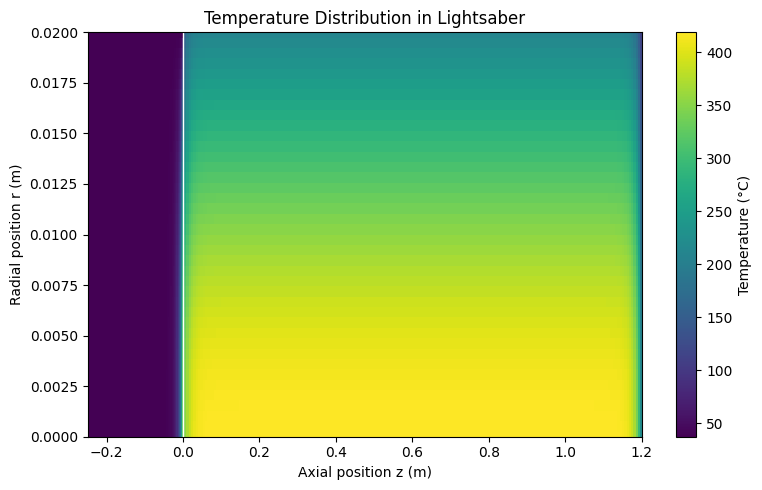

In [ ]:
#---------------------#
# Manipulate and Plot #
#---------------------#

T_coreC = T_core.copy() - 273.15
T_handleC = T_handle.copy() - 273.15

T_handle_flipped = np.zeros(T_handleC.shape)
i = 0
while i < n:
    j = 0
    while j < M:
        T_handle_flipped[i,j] = T_handleC[i,MInd -j]
        j += 1
    i += 1

'''
print("tcore:")
print(T_core)
print("T_handle:")
print(T_handle)
'''

#plotting with the help of ChatGPT
Nr, Nz_core = T_coreC.shape
Nr, Nz_handle = T_handleC.shape

# Define the original radial and axial coordinates
r = np.linspace(0, r_core, Nr)
z_core = np.linspace(0, L_1, Nz_core)
z_handle = np.linspace(-L_2, 0, Nz_handle)

#correct the physical lengths to reflect the control volume sizes
i = 1
while i < max(len(z_core), len(z_handle), len(r)):
    if i < len(z_core):
        z_core[i] -= dx_c/2
    if i < len(z_handle):
        z_handle[i] -= dx_h/2
    if i < len(r):
        r[i] -= dr/2
    i += 1

z_core = np.append(z_core, z_core[-1] + dx_c/2)
z_handle = np.append(z_handle, z_handle[-1] + dx_h/2)
r = np.append(r, r[-1] + dr/2)

# Meshgrid for plotting
R_core, Z_core = np.meshgrid(r, z_core, indexing='ij')
R_handle, Z_handle = np.meshgrid(r, z_handle, indexing='ij')

# Get min/max for consistent color scaling
tmin = min(T_coreC.min(), T_handleC.min())
tmax = max(T_coreC.max(), T_handleC.max())

# Plot
plt.figure(figsize=(16, 8))
plt.axvline(x=0, color='white', linestyle='-', linewidth=1)
plt.pcolormesh(Z_core, R_core, T_coreC, cmap='viridis', shading='flat', vmin=tmin, vmax=tmax)
plt.pcolormesh(Z_handle, R_handle, T_handle_flipped, cmap='viridis', shading='flat', vmin=tmin, vmax=tmax)
plt.colorbar(label='Temperature (°C)')
plt.xlabel('Axial position z (m)')
plt.ylabel('Radial position r (m)')
plt.title('Temperature Distribution in Lightsaber')
plt.tight_layout()
plt.show()
